# Clone Portal users, groups and content



In [2]:
from arcgis.gis import GIS
from IPython.display import display
from getpass import getpass

## Define the source and target portals
To start with, define the source and target portals. Connect to them using accounts with administrative privileges:

In [4]:
source_password = getpass()
target_password = getpass()
source = GIS("https://dev005513.esri.com/portal", 'admin', source_password)
target = GIS("https://agsapipor1.esri.com/portal", 'admin', target_password)
target_admin_username = 'admin'

········
········


# Users
List the users in the source and target portals. We do not want to copy over system accounts since those would be available in the target portal as well. Hence, filter the search by negating any account that starts with 'esri_'. We also do not want to copy over the [initial administrator account](http://server.arcgis.com/en/portal/latest/administer/linux/about-the-initial-administrator-account.htm) as one would be present in the target as well. Hence, negate the account that starts with `admin` which happens to be the administrator account on source portal.

In [5]:
#!esri_ & !admin
# source_users = source.users.search()
source_users = source.users.search('!esri_ & !admin')
for user in source_users:
    print(user.username + "\t:\t" + str(user.role))
#     print(user.username)

brown.rogers	:	org_user
davis.reed	:	org_admin
johnson.stewart	:	org_user
jones.morris	:	org_user
miller.cook	:	org_publisher
moore.bell	:	org_publisher
smith.collins	:	org_admin
taylor.murphy	:	org_publisher
williams.sanchez	:	org_user
wilson.morgan	:	org_publisher


Get the number of users to migrate:

In [6]:
len(source_users)

10

Get the list of users already present in the target portal. Similar to earlier, filter out system and initial administrator accounts. The name of the admin account on target portal is `admin` as well in this example.

In [7]:
# filter out system and initial administrator accounts
target_users = target.users.search('!esri_ & !admin & !system_publisher')
target_users

[]

If users found on source portal were already in the target portal, run the following code to delete them. You can choose to not delete them as well.

### Remove existing users from target portal
If you want to clean up the target portal except for the initial administrator account, run the cell below. As you delete, you may opt to assign their content to the initial administrator account.

In [8]:
for source_user in source_users:
    try:
        target_user = target.users.get(source_user.username)
        if target_user is not None:
            print('Deleting user: ' + target_user.fullName)
            target_user.reassign_to(target_admin_username)
            target_user.delete()
    except:
        print('User {} does not exist in Target Portal'.format(source_user.username))

### Copy Users
Create a function that will accept connection to the target portal, `User` objects from source portal and password to create users with. In addition to creating the users, this function will set their access, description, tags and other similar properties from source. If a user by the same name already exists in the target portal (possible if you opted not to clean out the target portal) then this function prints out an error message.

In [9]:
def copy_user(target_portal, source_user, password):
    # See if the user has firstName and lastName properties
    try:
        first_name = source_user.firstName
        last_name = source_user.lastName
    except:
        # if not, split the fullName
        full_name = source_user.fullName
        first_name = full_name.split()[0]
        try:
            last_name = full_name.split()[1]
        except:
            last_name = 'NoLastName'

    try:
        # create user
        target_user = target_portal.users.create(source_user.username, password, first_name, 
                                                 last_name, source_user.email, 
                                                 source_user.description, source_user.role)

        # update user properties
        target_user.update(source_user.access, source_user.preferredView,
                           source_user.description, source_user.tags, 
                           source_user.get_thumbnail_link(),
                           culture=source_user.culture, region=source_user.region)
        return target_user
    
    except Exception as Ex:
        print(str(Ex))
        print("Unable to create user "+ source_user.username)
        return None

For each user in source portal, make a corresponding user in target portal. In this sample, we provide a common password to all users `TestPassword@123` as we are creating users off the built-in identity store. If you are creating users off your enterprise identity store, you can ignore the `password` parameter and use the `provider` and `idp_username` parameters as explained in the [API reference doc](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.html#arcgis.gis.UserManager.create).

In [10]:
for user in source_users:
    print("Creating user: " + user.username)
    copy_user(target, user, 'TestPassword@123')

Creating user: brown.rogers
Creating user: davis.reed
Creating user: johnson.stewart
Creating user: jones.morris
Creating user: miller.cook
Creating user: moore.bell
Creating user: smith.collins
Creating user: taylor.murphy
Creating user: williams.sanchez
Creating user: wilson.morgan


Verify that users have been added to target portal:

In [11]:
target_users = target.users.search()
target_users

[<User username:admin>,
 <User username:brown.rogers>,
 <User username:davis.reed>,
 <User username:esri_boundaries>,
 <User username:esri_demographics>,
 <User username:esri_livingatlas>,
 <User username:esri_nav>,
 <User username:johnson.stewart>,
 <User username:jones.morris>,
 <User username:miller.cook>,
 <User username:moore.bell>,
 <User username:smith.collins>,
 <User username:system_publisher>,
 <User username:taylor.murphy>,
 <User username:williams.sanchez>,
 <User username:wilson.morgan>]

Thus, users have been successfully added to the target portal

# Groups

List the groups in the source and target portals. Similar to how we searched for users, we will ignore the system created and default groups as they would be available on the target portal as well.

In [12]:
# filter out system created groups
source_groups = source.groups.search("!owner:esri_* & !Basemaps")
source_groups

[<Group title:"Central Services" owner:admin>,
 <Group title:"Compliance" owner:admin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>,
 <Group title:"Demographic Content" owner:admin>,
 <Group title:"Featured Maps and Apps" owner:admin>]

In [13]:
target_groups = target.groups.search("!owner:esri_* & !Basemaps")
target_groups

[<Group title:"Featured Maps and Apps" owner:admin>]

If any of the groups from source are already in the target, run the following code to delete them. If the group belongs to any of default user accounts, don't delete it. This step is optional, you may choose to not delete those groups if you prefer to retain them as is.

In [14]:
for tg in target_groups:
    for sg in source_groups:
        if sg.title == tg.title and (not tg.owner.startswith('esri_')):
            print("Cleaning up group {} in target Portal...".format(tg.title))
            tg.delete()
            break

Cleaning up group Featured Maps and Apps in target Portal...


## Copy Groups

Let us create a function that will clone the groups one at a time. As you call this function in a loop for each group, it reads the source group's properties, downloads thumbnail into a temporary file then creates a similar named group on target and applies those properties and thumbnail. If one of your portals is an organization on ArcGIS Online and other is an ArcGIS Enterprise, certain privacy properties need to be adapted. This function takes care of that. After creating the group, it finds which users were members of it and adds them appropriately.

In [15]:
import tempfile

GROUP_COPY_PROPERTIES = ['title', 'description', 'tags', 'snippet', 'phone',
                         'access', 'isInvitationOnly']

def copy_group(target, source, source_group):
    
    with tempfile.TemporaryDirectory() as temp_dir:
        try:
            target_group = {}

            for property_name in GROUP_COPY_PROPERTIES:
                target_group[property_name] = source_group[property_name]

            if source_group['access'] == 'org' and target.properties['portalMode'] == 'singletenant':
                #cloning from ArcGIS Online to ArcGIS Enterprise
                target_group['access'] = 'public'

            elif source_group['access'] == 'public'\
                 and source.properties['portalMode'] == 'singletenant'\
                 and target.properties['portalMode'] == 'multitenant'\
                 and 'id' in target.properties:
                    #cloning from ArcGIS Enterprise to ArcGIS Online org
                    target_group['access'] = 'org'

            # Download the thumbnail (if one exists)
            thumbnail_file = None
            if 'thumbnail' in group:
                target_group['thumbnail'] = group.download_thumbnail(temp_dir)

            # Create the group in the target portal
            copied_group = target.groups.create_from_dict(target_group)

            # Reassign all groups to correct owners, add users, and find shared items
            members = group.get_members()
            if not members['owner'] == target_admin_username:
                copied_group.reassign_to(members['owner'])
            if members['users']:
                copied_group.add_users(members['users'])
            return copied_group
        except:
            print("Error creating " + source_group['title'])

For each group in source portal, make a corresponding group in target portal.

<Group title:"Central Services" owner:admin>
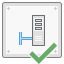

<Group title:"Compliance" owner:admin>
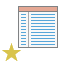

<Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>
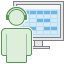

<Group title:"Demographic Content" owner:admin>
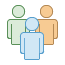

<Group title:"Featured Maps and Apps" owner:admin>

In [16]:
from IPython.display import display
for group in source_groups:
    target_group = copy_group(target, source, group)
    if target_group:
        display(target_group)

As you can see, we were able to add the groups with their thumbnails. Now let us verify that groups can be listed on the target portal:

In [17]:
target_groups = target.groups.search()
target_groups

[<Group title:"Central Services" owner:admin>,
 <Group title:"Compliance" owner:admin>,
 <Group title:"Customer Service, Finance, Billing and Accounting" owner:admin>,
 <Group title:"Demographic Content" owner:admin>,
 <Group title:"Esri Boundary Layers" owner:esri_boundaries>,
 <Group title:"Esri Demographic Layers" owner:esri_demographics>,
 <Group title:"Featured Maps and Apps" owner:admin>,
 <Group title:"Living Atlas" owner:esri_livingatlas>,
 <Group title:"Living Atlas Analysis Layers" owner:esri_livingatlas>,
 <Group title:"Navigator Maps" owner:esri_nav>]

With this part of the sample, we have successfully created users, groups and added the appropriate users to these groups. Thus, you can call the `get_members()` method one of the groups to view its members:

In [18]:
group1 = target_groups[0]
group1.get_members()

{'admins': ['admin'],
 'owner': 'admin',
 'users': ['brown.rogers',
  'johnson.stewart',
  'smith.collins',
  'taylor.murphy']}

# Items

Copying items consists of multiple steps as explained in the following section of the sample:

 1. [For each user create a mapping of itemId to the `Item`](#For-each-user-create-a-mapping-of-itemId-to-the-Item)
 2. [Prepare sharing information for each item](#Prepare-sharing-information-for-each-item)
   1. [Print a mapping of item and its group membership](#Print-a-mapping-of-item-and-its-group-membership)
 3. [Copy items one by one](#Copy-Items)
 4. [Establish relationship between items](#establish-relationship-between-items)

## For each user create a mapping of itemId to the `Item`
Do this for every folder in the user's account on the source portal

In [19]:
source_items_by_id = {}
for user in source_users:
    num_items = 0
    num_folders = 0
    print("Collecting item ids for {}".format(user.username), end="\t\t")
    user_content = user.items()
    
    # Get item ids from root folder first
    for item in user_content:
        num_items += 1
        source_items_by_id[item.itemid] = item 
    
    # Get item ids from each of the folders next
    folders = user.folders
    for folder in folders:
        num_folders += 1
        folder_items = user.items(folder=folder['title'])
        for item in folder_items:
            num_items += 1
            source_items_by_id[item.itemid] = item
    
    print("Number of folders {} # Number of items {}".format(str(num_folders), str(num_items)))

Let us print the dictionary of `{item_id : Item object}`

In [20]:
source_items_by_id

{'001d9c32cd644ccbb5b3df41e39d1f18': <Item title:"AR" type:CSV owner:brown.rogers>,
 '035233eb258c46918056a0c5b8019a43': <Item title:"IN" type:Feature Layer Collection owner:williams.sanchez>,
 '062b6b2c15d34bdb94a18148882e6c79': <Item title:"IN" type:CSV owner:williams.sanchez>,
 '0cbd54a8a0eb4fccbc2848661d6e94da': <Item title:"Smith Collins response locations" type:Web Map owner:smith.collins>,
 '1bcb8074538943ae837a1300a7171ebf': <Item title:"Wilson Morgan response locations" type:Web Map owner:wilson.morgan>,
 '1bed1dfc23664fc686fce80af433a7b6': <Item title:"ID" type:CSV owner:wilson.morgan>,
 '3b51fdf1569c408c97e46b2057264bdf': <Item title:"Jones Morris response locations" type:Web Map owner:jones.morris>,
 '539dc28aa20c40c5a3e813dfe9234c16': <Item title:"NC" type:Feature Layer Collection owner:jones.morris>,
 '547f8c6539834d2bb8ee7f858b6e3381': <Item title:"Miller Cook response locations" type:Web Map owner:miller.cook>,
 '59b74d125ca04f07b1334635d9f492bc': <Item title:"Brown Rog

## Prepare sharing information for each item
Using the dictionary we created above, find to which groups are each of the items shared to.

In [21]:
for group in source_groups:
    #iterate through each item shared to the source group
    for group_item in group.content():
        try:
            #get the item
            item = source_items_by_id[group_item.itemid]
            if item is not None:
                if not 'groups'in item:
                    item['groups'] = []
                
                #assign the target portal's corresponding group's name
                item['groups'].append(group['title'])
        except:
            print("Cannot find item : " + group_item.itemid)

### Print a mapping of item and its group membership

In [27]:
for key in source_items_by_id.keys():
    item = source_items_by_id[key]
    print("\n{:40s}".format(item.title), end = " # ")
    if 'groups' in item:
        print(item.access, end = " # ")
        print(item.groups, end = "")


Jones Morris response locations          # shared # ['Customer Service, Finance, Billing and Accounting']
NC                                       # 
Davis Reed response locations            # shared # ['Demographic Content']
Wilson Morgan response locations         # shared # ['Compliance', 'Demographic Content']
NH                                       # 
AR                                       # 
Taylor Murphy response locations         # shared # ['Central Services', 'Compliance']
Williams Sanchez response locations      # shared # ['Customer Service, Finance, Billing and Accounting']
AZ                                       # 
LA                                       # 
Brown Rogers response locations          # shared # ['Central Services']
FL                                       # 
Smith Collins response locations         # shared # ['Central Services']
Moore Bell response locations            # shared # ['Compliance', 'Demographic Content']
IN                                

As we can see from above, some items are shared to a few groups while some are not.

## Copy Items
Below we define a function that you can call in a loop for each item in the dictionary we composed earlier. If the item is a text based item such as a Web Map or a file based item such as a layer package, it downloads the item's data to a temporary directory and uses that for creating the target item during cloning. You can find the [exhaustive list of different items](http://doc.arcgis.com/en/arcgis-online/reference/supported-items.htm) that you can upload to your portal and their corresponding item types from the [REST API documentation](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#/Items_and_item_types/02r3000000ms000000/). For brevity, this sample covers only a subset of those items. Note, if the item points to a web layer URL, the target item would also point to the same URL.

In [30]:
TEXT_BASED_ITEM_TYPES = frozenset(['Web Map', 'Feature Service', 'Map Service','Web Scene',
                                   'Image Service', 'Feature Collection', 
                                   'Feature Collection Template',
                                   'Web Mapping Application', 'Mobile Application', 
                                   'Symbol Set', 'Color Set',
                                   'Windows Viewer Configuration'])

FILE_BASED_ITEM_TYPES = frozenset(['File Geodatabase','CSV', 'Image', 'KML', 'Locator Package',
                                  'Map Document', 'Shapefile', 'Microsoft Word', 'PDF',
                                  'Microsoft Powerpoint', 'Microsoft Excel', 'Layer Package',
                                  'Mobile Map Package', 'Geoprocessing Package', 'Scene Package',
                                  'Tile Package', 'Vector Tile Package'])

ITEM_COPY_PROPERTIES = ['title', 'type', 'typeKeywords', 'description', 'tags',
                        'snippet', 'extent', 'spatialReference', 'name',
                        'accessInformation', 'licenseInfo', 'culture', 'url']

We define the copy function for items below. This function gets the properties of the item from source and applies it to the target. If the items were saved inside a folder, it creates that folder on the target as well. Finally, it sets the privacy (sharing) properties similar to how it was on the source portal.

In [31]:
def copy_item(target, source_item):
    try:
        with tempfile.TemporaryDirectory() as temp_dir:
            item_properties = {}
            for property_name in ITEM_COPY_PROPERTIES:
                item_properties[property_name] = source_item[property_name]

            data_file = None
            
            if source_item.type in TEXT_BASED_ITEM_TYPES:
                # If its a text-based item, then read the text and add it to the request.
                text = source_item.get_data(False)
                item_properties['text'] = text
            
            elif source_item.type in FILE_BASED_ITEM_TYPES:
                # download data and add to the request as a file
                data_file = source_item.download(temp_dir)

            thumbnail_file = source_item.download_thumbnail(temp_dir)
            metadata_file = source_item.download_metadata(temp_dir)

            #find item's owner
            source_item_owner = source.users.search(source_item.owner)[0]
            
            #find item's folder
            item_folder_titles = [f['title'] for f in source_item_owner.folders 
                                  if f['id'] == source_item.ownerFolder]
            folder_name = None
            if len(item_folder_titles) > 0:
                folder_name = item_folder_titles[0]

            #if folder does not exist for target user, create it
            if folder_name:
                target_user = target.users.search(source_item.owner)[0]
                target_user_folders = [f['title'] for f in target_user.folders
                                       if f['title'] == folder_name]
                if len(target_user_folders) == 0:
                    #create the folder
                    target.content.create_folder(folder_name, source_item.owner)
            
            # Add the item to the target portal, assign owner and folder
            target_item = target.content.add(item_properties, data_file, thumbnail_file, 
                                             metadata_file, source_item.owner, folder_name)
            
            #Set sharing (privacy) information
            share_everyone = source_item.access == 'public'
            share_org = source_item.access in ['org', 'public']
            share_groups = []
            if source_item.access == 'shared':
                share_groups = source_item.groups
            
            target_item.share(share_everyone, share_org, share_groups)
            
            return target_item
        
    except Exception as copy_ex:
        print("\tError copying " + source_item.title)
        print("\t" + str(copy_ex))
        return None

Copy over each item. While doing so, construct a dictionary mapping of source item's ID with target item's ID

In [32]:
source_target_itemId_map = {}
for key in source_items_by_id.keys():
    source_item = source_items_by_id[key]

    print("Copying {} \tfor\t {}".format(source_item.title, source_item.owner))
    target_item = copy_item(target, source_item)
    if target_item:
        source_target_itemId_map[key] = target_item.itemid
    else:
        source_target_itemId_map[key] = None

Copying Jones Morris response locations 	for	 jones.morris
Copying NC 	for	 jones.morris
Copying Davis Reed response locations 	for	 davis.reed
Copying Wilson Morgan response locations 	for	 wilson.morgan
Copying NH 	for	 miller.cook
Copying AR 	for	 brown.rogers
Copying Taylor Murphy response locations 	for	 taylor.murphy
Copying Williams Sanchez response locations 	for	 williams.sanchez
Copying AZ 	for	 moore.bell
Copying LA 	for	 taylor.murphy
Copying Brown Rogers response locations 	for	 brown.rogers
Copying FL 	for	 davis.reed
Copying Smith Collins response locations 	for	 smith.collins
Copying Moore Bell response locations 	for	 moore.bell
Copying IN 	for	 williams.sanchez
Copying NV 	for	 johnson.stewart
Copying ID 	for	 wilson.morgan
Copying NC 	for	 jones.morris
Copying LA 	for	 taylor.murphy
Copying AR 	for	 brown.rogers
Copying IN 	for	 williams.sanchez
Copying Johnson Stewart response locations 	for	 johnson.stewart
Copying ID 	for	 wilson.morgan
Copying NV 	for	 johnson.st

We have successfully cloned all the items from source to target. We can query the contents of one of the users below to verify:

<User username:davis.reed>
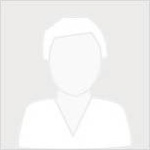

In [33]:
user1 = target.users.search()[2]
user1

In [34]:
user1.items()

[<Item title:"FL" type:Feature Layer Collection owner:davis.reed>,
 <Item title:"FL" type:CSV owner:davis.reed>]

We could query the folders belonging to this user and the items within as well

In [35]:
user1.folders

[{'created': 1499896304064,
  'id': '193d1df376af48768a0886ab334c981b',
  'title': 'Reed_webmaps',
  'username': 'davis.reed'}]

In [36]:
user1.items(folder=user1.folders[0]['title'])

[<Item title:"Davis Reed response locations" type:Web Map owner:davis.reed>]

## Establish relationship between items

So far, we have successfully cloned users, groups and items from source to target. Next, we will establish identical [relationships](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#/Relationship_types/02r3000000mm000000/) between items as they were in the source portal.

In [37]:
RELATIONSHIP_TYPES = frozenset(['Map2Service', 'WMA2Code',
                                'Map2FeatureCollection', 'MobileApp2Code', 'Service2Data',
                                'Service2Service'])

Below, we loop through each item in source portal, find to which other item it is related and the type of that relationship. If a relationship is found, we find the corresponding items in target and establish the same relationship. To make this work, we will make use of the dictionary that maps the itemIds on source and target we created during the item clone stage. Let us take a look at that dictionary below:

In [38]:
source_target_itemId_map

{'001d9c32cd644ccbb5b3df41e39d1f18': 'b488e717bc91445da52b0b60155a622c',
 '035233eb258c46918056a0c5b8019a43': 'b393fbd3e4244e499a90f9807e49a075',
 '062b6b2c15d34bdb94a18148882e6c79': '8c4b109221e14fcb8cd71336307455c2',
 '0cbd54a8a0eb4fccbc2848661d6e94da': '1ce082263fb344a2a8a5e63757d72785',
 '1bcb8074538943ae837a1300a7171ebf': '0b31142e54bc4e09ac487df112d00ade',
 '1bed1dfc23664fc686fce80af433a7b6': 'ca2eb901c07044c9878e9736044a6dde',
 '3b51fdf1569c408c97e46b2057264bdf': '99f65d4c94404581b30573fadbf58776',
 '539dc28aa20c40c5a3e813dfe9234c16': '09a67275037b42749cff8d4d78e009f4',
 '547f8c6539834d2bb8ee7f858b6e3381': '3e0235db2e634a6d9a7200e1789b29c9',
 '59b74d125ca04f07b1334635d9f492bc': 'a3e5ec7b59584a08ac17e9ea2be0f794',
 '6fb53825b23045598287ec0452482dca': '43555c6470644c5386167f2785040729',
 '745738a55b7141d19cd9d8ce23efb0bd': '9415190543ad4ea4a4655b016e2cf0c7',
 '74b90c924b0c4664ba9a52e4ef3c13f6': 'b454eb36fc2742a2870f72081dbab4f0',
 '796b4ddbfc564d33bd5b8fc9f82fb326': 'e73b394f7fea4

In [39]:
for key in source_target_itemId_map.keys():
    source_item = source_items_by_id[key]
    target_itemid = source_target_itemId_map[key]
    target_item = target.content.get(target_itemid)

    print(source_item.title + " # " + source_item.type)
    for relationship in RELATIONSHIP_TYPES:
        try:
            source_related_items = source_item.related_items(relationship)
            for source_related_item in source_related_items:
                print("\t\t" + source_related_item.title + " # " + 
                      source_related_item.type +"\t## " + relationship)

                #establish same relationship amongst target items
                print("\t\t" + "establishing relationship in target portal", end=" ")
                target_related_itemid = source_target_itemId_map[source_related_item.itemid]
                target_related_item = target.content.get(target_related_itemid)
                status = target_item.add_relationship(target_related_item, relationship)
                print(str(status))
        except Exception as rel_ex:
            print("\t\t Error when checking for " + relationship + " : " + str(rel_ex))
            continue

Jones Morris response locations # Web Map
NC # Feature Service
		NC # CSV	## Service2Data
		establishing relationship in target portal True
Davis Reed response locations # Web Map
AZ # CSV
NH # Feature Service
		NH # CSV	## Service2Data
		establishing relationship in target portal True
AR # Feature Service
		AR # CSV	## Service2Data
		establishing relationship in target portal True
Taylor Murphy response locations # Web Map
Williams Sanchez response locations # Web Map
AZ # Feature Service
		AZ # CSV	## Service2Data
		establishing relationship in target portal True
LA # CSV
Brown Rogers response locations # Web Map
FL # Feature Service
		FL # CSV	## Service2Data
		establishing relationship in target portal True
Smith Collins response locations # Web Map
Moore Bell response locations # Web Map
IN # CSV
NV # CSV
ID # Feature Service
		ID # CSV	## Service2Data
		establishing relationship in target portal True
NC # CSV
LA # Feature Service
		LA # CSV	## Service2Data
		establishing relation

## Clone the styling

In [40]:
banner_path = source.admin.ux.get_banner(r'E:\code\geosaurus\g_presentations\2017_UC\clone_45mins\styles')
background_path = source.admin.ux.get_background(r'E:\code\geosaurus\g_presentations\2017_UC\clone_45mins\styles')

### set the styling

In [41]:
target.admin.ux.set_banner(banner_path)
target.admin.ux.set_background(background_path)

True